In [1]:
from tqdm.notebook import tnrange

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sigmaclip as sigmaclip
import astropy.constants as const
from tqdm.notebook import tnrange
from functools import partial
import multiprocess as mp

from function import med_n_lim

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading SYSREM results

numorder, numframe, numwv, n_sys = 22, 56, 4080, 10

#for propagation error
flux_data = np.zeros((numorder,n_sys+1,numframe,numwv))
error_data = flux_data.copy()
wave_data = flux_data.copy()
a_data = np.zeros((numorder,n_sys+1,numframe))
c_data = np.zeros((numorder,n_sys+1,numwv))

for order in range(numorder):
    for sysiter in range(n_sys+1):

    #reading hdf5 file for each SYSREM iteration (default binmedfil=151)
        with h5py.File('data/hdf5/HD149026b-after-#'+str(sysiter)+'-SYSREM-iteration-sys-MJD_to_BJD.hdf5', 'r') as h5f_raw:

            flux_data[order,sysiter] = h5f_raw['flux-order-'+str(order)][()]
            error_data[order,sysiter] = h5f_raw['error-poisson-order-'+str(order)][()]
            wave_data[order,sysiter] = h5f_raw['wv-vac-order-'+str(order)][()]
            airmass = h5f_raw['airmass'][()]
            rvcor = h5f_raw['rv_cor'][()]
            bjd = h5f_raw['bjd'][()]
            jd = h5f_raw['jd'][()]
            phase = h5f_raw['phase'][()]
            rel_phase = h5f_raw['rel_phase'][()]
            hour_phase = h5f_raw['hour_phase'][()]
            exptime = h5f_raw['exp_time'][()]
            out_transit_mask = h5f_raw['out_transit_mask'][()]
            transit_weight = h5f_raw['transit_weight'][()]
            carm_order = h5f_raw['carm_order'][()]
            contact_index = h5f_raw['contact_index'][()]

            if sysiter != 0:
                a_data[order,sysiter-1] = h5f_raw['a-coeff-order-'+str(order)][()]
                c_data[order,sysiter-1] = h5f_raw['c-coeff-order-'+str(order)][()]

In [3]:
# reading grid search results

with h5py.File('data/hdf5/3D_grid_search_Kp50-250-1d60_Vrestm10-10-0d1_A0-3-0d01_withframe#44.hdf5', 'r') as h5f_raw:

    Likelihood_F_w44 = h5f_raw['Likelihood_F'][()]
    Ndata = h5f_raw['Ndata'][()]
    K1_loop = h5f_raw['K1_loop'][()]
    K2_loop = h5f_raw['K2_loop'][()]
    CC_loop = h5f_raw['CC_loop'][()]

In [4]:
# reading grid search results

with h5py.File('data/hdf5/3D_grid_search_Kp50-250-1d60_Vrestm10-10-0d1_A0-3-0d01_woframe#44.hdf5', 'r') as h5f_raw:

    Likelihood_F_wo44 = h5f_raw['Likelihood_F'][()]
    Ndata = h5f_raw['Ndata'][()]
    K1_loop = h5f_raw['K1_loop'][()]
    K2_loop = h5f_raw['K2_loop'][()]
    CC_loop = h5f_raw['CC_loop'][()]

In [5]:
# reading grid search results

with h5py.File('data/hdf5/3D_grid_search_Kp50-250-1d60_Vrestm10-10-0d1_A0-3-0d01_wopreprocess.hdf5', 'r') as h5f_raw:

    Likelihood_F_nopreproc = h5f_raw['Likelihood_F'][()]
    Ndata_nopreproc = h5f_raw['Ndata'][()]
    K1_loop_nopreproc = h5f_raw['K1_loop'][()]
    K2_loop_nopreproc = h5f_raw['K2_loop'][()]
    CC_loop_nopreproc = h5f_raw['CC_loop'][()]

In [6]:
Kp_sample = np.arange(50,250,1.60)       # in km/s
Vrest_sample_wo44 = np.arange(-10.,10.,0.1)     # in km/s
Vrest_sample_w44 = np.arange(-10.,10.,0.1)     # in km/s
A_sample = np.arange(0.,3.,0.01)

def calc(likelihood,Vrest_sample):
    Kp_marg = likelihood.sum(axis=(0, 2))
    Vrest_marg = likelihood.sum(axis=(0, 1))
    A_marg = likelihood.sum(axis=(1, 2)) 

    A_med_std = med_n_lim(A_sample, A_marg)
    Vrest_med_std = med_n_lim(Vrest_sample, Vrest_marg)
    Kp_med_std = med_n_lim(Kp_sample, Kp_marg)

    return Kp_marg, Vrest_marg, A_marg, Kp_med_std, Vrest_med_std, A_med_std

In [7]:
Kp_marg_w44, Vrest_marg_w44, A_marg_w44, Kp_med_std_w44, Vrest_med_std_w44, A_med_std_w44 = calc(Likelihood_F_w44,Vrest_sample_w44)
Kp_marg_wo44, Vrest_marg_wo44, A_marg_wo44, Kp_med_std_wo44, Vrest_med_std_wo44, A_med_std_wo44 = calc(Likelihood_F_wo44,Vrest_sample_wo44)
Kp_marg_w44_nopreproc, Vrest_marg_w44_nopreproc, A_marg_w44_nopreproc, Kp_med_std_w44_nopreproc, Vrest_med_std_w44_nopreproc, A_med_std_w44_nopreproc = calc(Likelihood_F_nopreproc,Vrest_sample_w44)

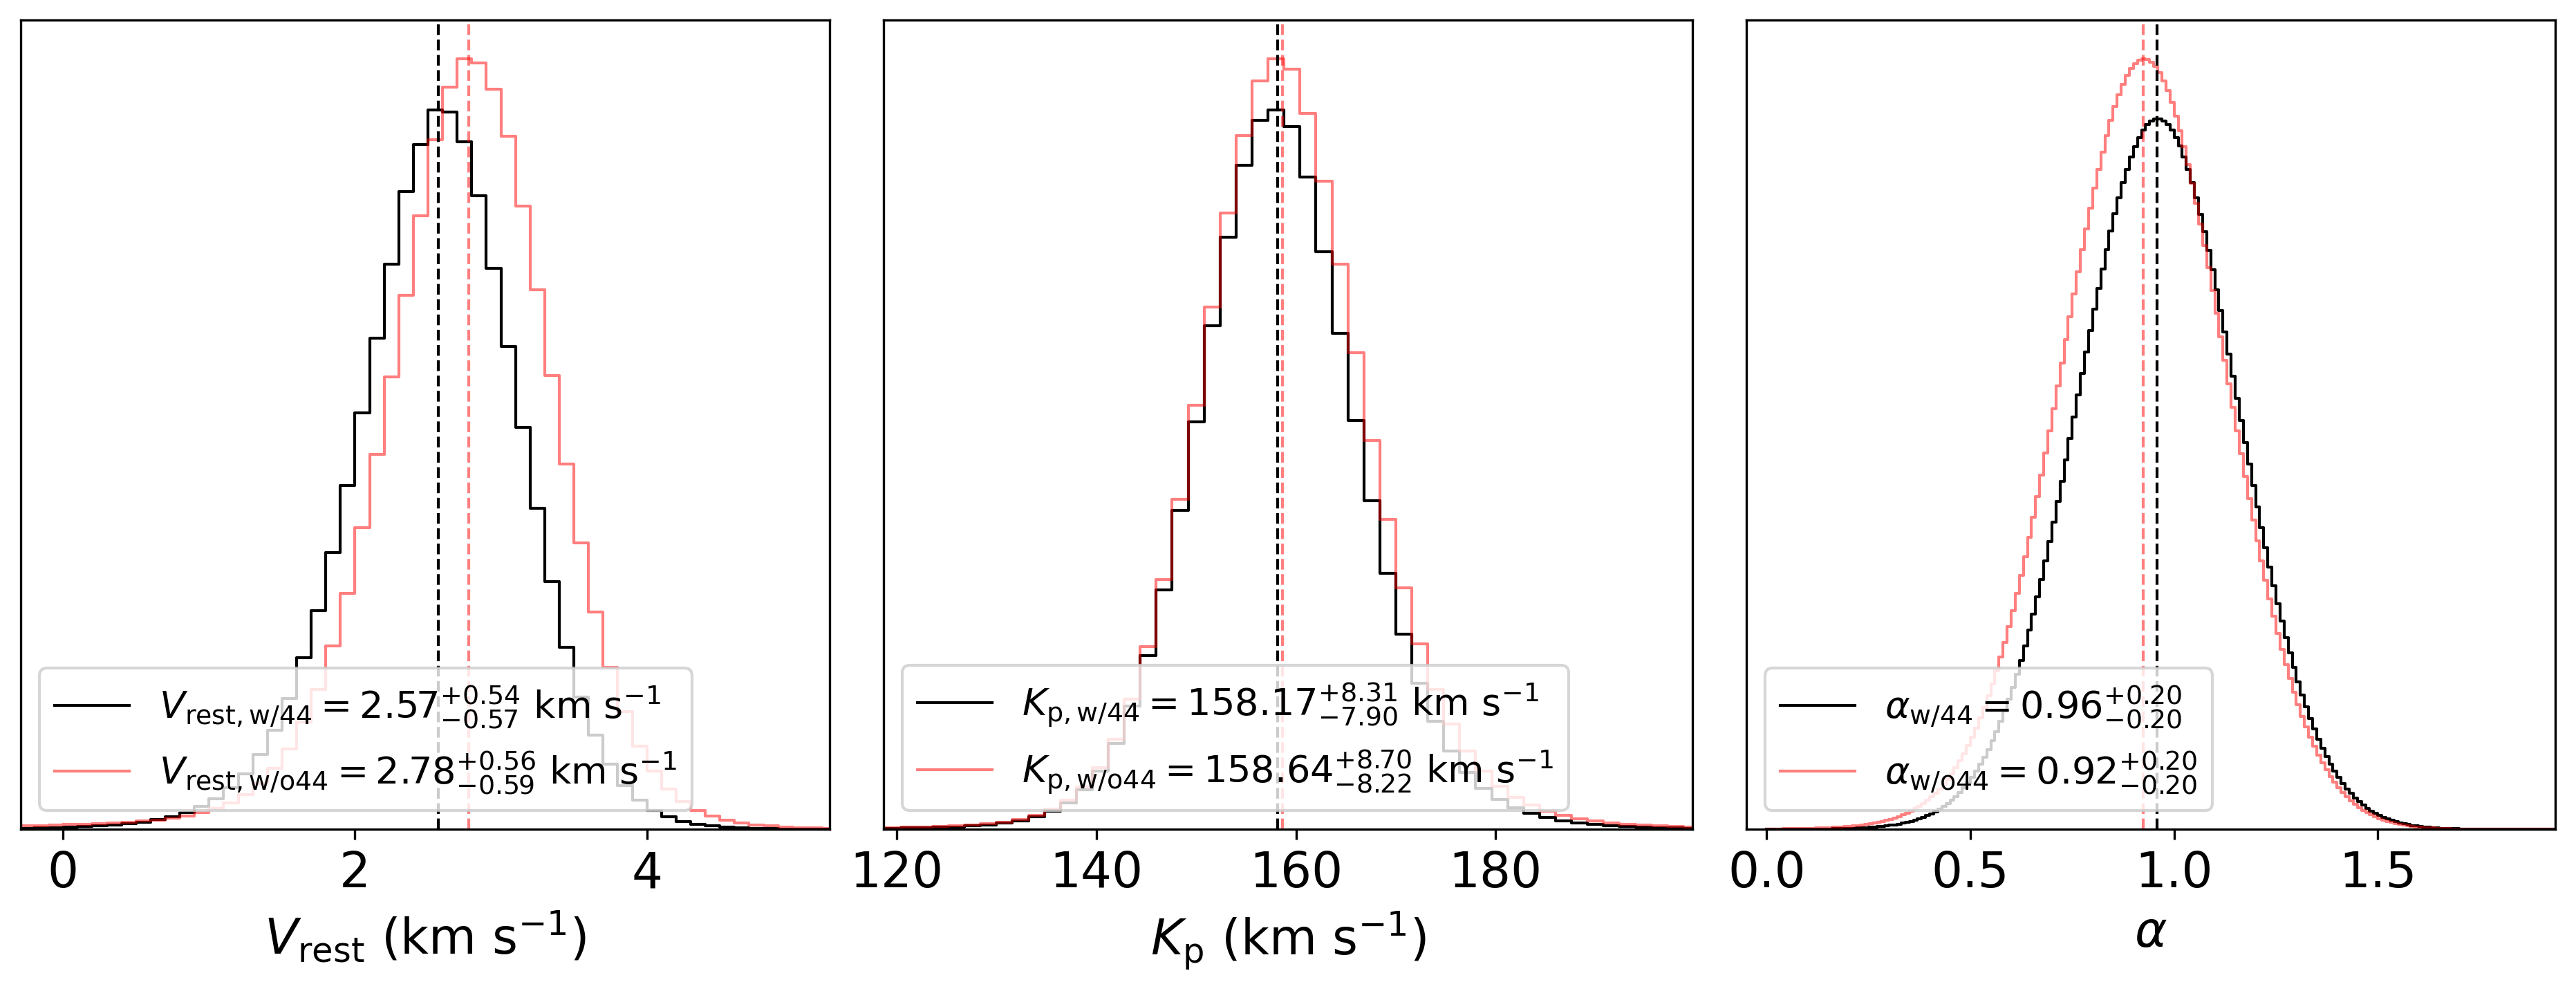

In [8]:
lbl = 17

axes_alpvsys = [0, 0, 0.3, 0.3]
axes_alpkp = [0 + 0.3 + 0.02, 0, 0.3, 0.3]
axes_alpmarg = [0 + 0.3 + 0.3 + 0.02 + 0.02, 0, 0.3, 0.3]

fig = plt.figure(figsize=(13, 13),dpi=300)
vsysmarg = plt.axes(axes_alpvsys)
kpmarg = plt.axes(axes_alpkp)
alpmarg = plt.axes(axes_alpmarg)

kpmarg.set_yticklabels([])
vsysmarg.set_yticklabels([])
alpmarg.set_yticklabels([])
kpmarg.tick_params(left=False)
vsysmarg.tick_params(left=False, labelleft=False)
alpmarg.tick_params(left=False)

vsysmarg.step(Vrest_sample_w44, Vrest_marg_w44, c="black", lw=1,label=r'$V_\mathrm{rest,w/44} = $' + str(round(Vrest_med_std_w44[1], 2)) + r'$^{+' + str("%.2f" % Vrest_med_std_w44[-1]) + '}_{-' + str(
    "%.2f" % abs(Vrest_med_std_w44[0])) + '}$ km s$^{-1}$')
vsysmarg.step(Vrest_sample_wo44, Vrest_marg_wo44, c="red", lw=1, alpha=0.5,label=r'$V_\mathrm{rest,w/o44} = $' + str(round(Vrest_med_std_wo44[1], 2)) + r'$^{+' + str("%.2f" % Vrest_med_std_wo44[-1]) + '}_{-' + str(
    "%.2f" % abs(Vrest_med_std_wo44[0])) + '}$ km s$^{-1}$')
# vsysmarg.step(Vrest_sample_w44, Vrest_marg_w44_nopreproc, c="blue", lw=1,label=r'$V_\mathrm{rest,w/o preproc} = $' + str(round(Vrest_med_std_w44_nopreproc[1], 2)) + r'$^{+' + str("%.2f" % Vrest_med_std_w44_nopreproc[-1]) + '}_{-' + str(
#     "%.2f" % abs(Vrest_med_std_w44_nopreproc[0])) + '}$ km s$^{-1}$')

vsysmarg.set_xlim([Vrest_med_std_w44[1] - 5 * abs(Vrest_med_std_w44[0]), Vrest_med_std_w44[1] + 5 * abs(Vrest_med_std_w44[-1])])
vsysmarg.set_ylim(bottom=0)
lw=1
vsysmarg.axvline(x=Vrest_med_std_w44[1], lw=lw, ls='--', c='black')
vsysmarg.axvline(x=Vrest_med_std_wo44[1], lw=lw, ls='--', c='red',alpha=0.5)
vsysmarg.tick_params(axis='both', which='major', labelsize=lbl)
vsysmarg.legend(loc='lower left',prop={'size': 13})

kpmarg.step(Kp_sample, Kp_marg_w44, c="black", lw=1,label=r'$K_\mathrm{p,w/44} = $' + str(round(Kp_med_std_w44[1], 2)) + r'$^{+' + str("%.2f" % Kp_med_std_w44[-1]) + '}_{-' + str(
    "%.2f" % abs(Kp_med_std_w44[0])) + '}$ km s$^{-1}$')
kpmarg.step(Kp_sample, Kp_marg_wo44, c="red", lw=1,alpha=0.5,label=r'$K_\mathrm{p,w/o44} = $' + str(round(Kp_med_std_wo44[1], 2)) + r'$^{+' + str("%.2f" % Kp_med_std_wo44[-1]) + '}_{-' + str(
    "%.2f" % abs(Kp_med_std_wo44[0])) + '}$ km s$^{-1}$')
# kpmarg.step(Kp_sample, Kp_marg_w44_nopreproc, c="blue", lw=1,label=r'$K_\mathrm{p,w/o preproc} = $' + str(round(Kp_med_std_w44_nopreproc[1], 2)) + r'$^{+' + str("%.2f" % Kp_med_std_w44_nopreproc[-1]) + '}_{-' + str(
#     "%.2f" % abs(Kp_med_std_w44_nopreproc[0])) + '}$ km s$^{-1}$')
kpmarg.set_xlim([Kp_med_std_w44[1] - 5 * abs(Kp_med_std_w44[0]),Kp_med_std_w44[1] + 5 * abs(Kp_med_std_w44[-1])])
kpmarg.set_ylim(bottom=0)
kpmarg.axvline(x=Kp_med_std_w44[1], lw=1, ls='--', c='black')
kpmarg.axvline(x=Kp_med_std_wo44[1], lw=lw, ls='--', c='red',alpha=0.5)
# kpmarg.axvline(x=Kp_med_std_w44[1] - 1 * abs(Kp_med_std_w44[0]), lw=1, ls='--', c='black')
# kpmarg.axvline(x=Kp_med_std_w44[1] + 1 * abs(Kp_med_std_w44[-1]), lw=1, ls='--', c='black')
kpmarg.tick_params(axis='both', which='major', labelsize=lbl)
kpmarg.legend(loc='lower left',prop={'size': 13})

alpmarg.step(A_sample, A_marg_w44, c='black', lw=1,label=r'$\alpha_\mathrm{w/44} = $' + str(round(A_med_std_w44[1], 2)) + r'$^{+' + str("%.2f" % A_med_std_w44[-1]) + '}_{-' + str(
    "%.2f" % abs(A_med_std_w44[0])) + '}$')
alpmarg.step(A_sample, A_marg_wo44, c='red', lw=1,alpha=0.5,label=r'$\alpha_\mathrm{w/o44} = $' + str(round(A_med_std_wo44[1], 2)) + r'$^{+' + str("%.2f" % A_med_std_wo44[-1]) + '}_{-' + str(
    "%.2f" % abs(A_med_std_wo44[0])) + '}$')
# alpmarg.step(A_sample, A_marg_w44_nopreproc, c='blue', lw=1,label=r'$\alpha_\mathrm{w/opreproc} = $' + str(round(A_med_std_w44_nopreproc[1], 2)) + r'$^{+' + str("%.2f" % A_med_std_w44_nopreproc[-1]) + '}_{-' + str(
#     "%.2f" % abs(A_med_std_w44_nopreproc[0])) + '}$')
alpmarg.axvline(x=A_med_std_w44[1], lw=1, ls='--', c='black')
alpmarg.axvline(x=A_med_std_wo44[1], lw=lw, ls='--', c='red',alpha=0.5)
# alpmarg.axvline(x=A_med_std_w44[1] - 1 * abs(A_med_std_w44[0]), lw=1, ls='--', c='black')
# alpmarg.axvline(x=A_med_std_w44[1] + 1 * abs(A_med_std_w44[-1]), lw=1, ls='--', c='black')
alpmarg.set_xlim([-0.05, A_med_std_w44[1] + 5 * abs(A_med_std_w44[-1])])
alpmarg.set_ylim(bottom=0)
alpmarg.tick_params(axis='both', which='major', labelsize=lbl)
alpmarg.legend(loc='lower left',prop={'size': 13})

alpmarg.set_xlabel(r"$\alpha$",fontsize=lbl)
vsysmarg.set_xlabel(r"$V_\mathrm{rest}$ (km s$^{-1}$)",fontsize=lbl)
kpmarg.set_xlabel(r"$K_\mathrm{p}$ (km s$^{-1}$)",fontsize=lbl)
plt.savefig("figures/posterior_w44_wo44.pdf",format="pdf",dpi=200,bbox_inches="tight",pad_inches=0.1)

fig.tight_layout()